# version 1

In [7]:
import os
import pandas as pd
import numpy as np
import json

import skimage.io as io
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

from pycocotools.coco import COCO
from tqdm import tqdm

In [8]:
GT_JSON = '../dataset/train.json'
PRED_CSV = '../sample_submission/train_sample.csv'
LABEL_NAME = ["General trash", "Paper", "Paper pack", "Metal", 
              "Glass", "Plastic", "Styrofoam", "Plastic bag", "Battery", "Clothing"]

# load ground truth
with open(GT_JSON, 'r') as outfile:
    test_anno = (json.load(outfile)) 
    # test_anno : 5개의 key('info', 'licenses', 'images', 'categories', 'annotations')들로 이루어진 dict
    # info : dataset 정보?
    # licenses : dataset licenses
    # images : 각 image들의 정보(file 위치, width, height, id <- image의 고유 번호)
    # categories : class 정보 (총 10개의 class)
    # annotations : 모든 iamge들의 annotation정보(category_id와 bbox 좌표, id <-annotation의 고유번호)

# load prediction
pred_df = pd.read_csv(PRED_CSV)

In [9]:
coco = COCO(GT_JSON)

file_names = [coco.loadImgs(i)[0]['file_name'] for i in coco.getImgIds()]

loading annotations into memory...
Done (t=0.18s)
creating index...
index created!


In [10]:
imgId = coco.getImgIds(imgIds = [10])
img = coco.loadImgs(imgId)[0]

annIds = coco.getAnnIds(imgIds=imgId,iscrowd=None)
anns = coco.loadAnns(annIds)

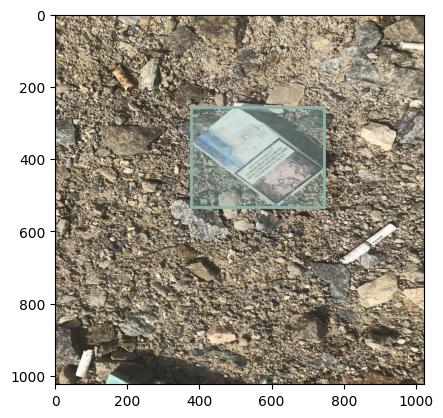

In [11]:
I = io.imread('../dataset/' + '/' + img['file_name'])
plt.imshow(I)

ax = plt.gca()
ax.set_autoscale_on(False)
polygons = []
color = []
for ann in anns:
    c = (np.random.random((1, 3))*0.6+0.4).tolist()[0]
    [bbox_x, bbox_y, bbox_w, bbox_h] = ann['bbox']
    poly = [[bbox_x, bbox_y], [bbox_x, bbox_y+bbox_h], [bbox_x+bbox_w, bbox_y+bbox_h], [bbox_x+bbox_w, bbox_y]]
    np_poly = np.array(poly).reshape((4,2))
    polygons.append(Polygon(np_poly))
    color.append(c)

p = PatchCollection(polygons, facecolor=color, linewidths=0, alpha=0.4)
ax.add_collection(p)
p = PatchCollection(polygons, facecolor='none', edgecolors=color, linewidths=2)
ax.add_collection(p)

# Version 2

In [19]:
import base64
import IPython
import json
import numpy as np
import os
import random
import requests
from io import BytesIO
from math import trunc
from PIL import Image as PILImage
from PIL import ImageDraw as PILImageDraw

In [20]:
class CocoDataset():
    def __init__(self, annotation_path, image_dir):
        self.annotation_path = annotation_path
        self.image_dir = image_dir
        self.colors = ['blue', 'purple', 'red', 'green', 'orange', 'salmon', 'pink', 'gold',
                        'orchid', 'slateblue', 'limegreen', 'seagreen', 'darkgreen', 'olive',
                        'teal', 'aquamarine', 'steelblue', 'powderblue', 'dodgerblue', 'navy',
                        'magenta', 'sienna', 'maroon']
        
        json_file = open(self.annotation_path)
        self.coco = json.load(json_file)
        json_file.close()
        
        #self.process_info()
        #self.process_licenses()
        self.process_categories()
        self.process_images()
        self.process_segmentations()

    def display_info(self):
        print('Dataset Info:')
        print('=============')
        for key, item in self.info.items():
            print('  {}: {}'.format(key, item))
        
        requirements = [['description', str],
                        ['url', str],
                        ['version', str],
                        ['year', int],
                        ['contributor', str],
                        ['date_created', str]]
        for req, req_type in requirements:
            if req not in self.info:
                print('ERROR: {} is missing'.format(req))
            elif type(self.info[req]) != req_type:
                print('ERROR: {} should be type {}'.format(req, str(req_type)))
        print('')
        
    def display_licenses(self):
        print('Licenses:')
        print('=========')
        
        requirements = [['id', int],
                        ['url', str],
                        ['name', str]]
        for license in self.licenses:
            for key, item in license.items():
                print('  {}: {}'.format(key, item))
            for req, req_type in requirements:
                if req not in license:
                    print('ERROR: {} is missing'.format(req))
                elif type(license[req]) != req_type:
                    print('ERROR: {} should be type {}'.format(req, str(req_type)))
            print('')
        print('')
        
    def display_categories(self):
        print('Categories:')
        print('=========')
        for sc_key, sc_val in self.super_categories.items():
            print('  super_category: {}'.format(sc_key))
            for cat_id in sc_val:
                print('    id {}: {}'.format(cat_id, self.categories[cat_id]['name']))
            print('')
    
    def display_image(self, image_id, show_polys=True, show_bbox=True, show_labels=True, show_crowds=True, use_url=False):
        print('Image:')
        print('======')
        if image_id == 'random':
            image_id = random.choice(list(self.images.keys()))
        
        # Print the image info
        image = self.images[image_id]
        for key, val in image.items():
            print('  {}: {}'.format(key, val))
            
        # Open the image
        if use_url:
            image_path = image['coco_url']
            response = requests.get(image_path)
            image = PILImage.open(BytesIO(response.content))
            
        else:
            image_path = os.path.join(self.image_dir, image['file_name'])
            image = PILImage.open(image_path)
            
        buffered = BytesIO()
        image.save(buffered, format="PNG")
        img_str = "data:image/png;base64, " + base64.b64encode(buffered.getvalue()).decode()
        
        # Calculate the size and adjusted display size
        max_width = 900
        image_width, image_height = image.size
        adjusted_width = min(image_width, max_width)
        adjusted_ratio = adjusted_width / image_width
        adjusted_height = adjusted_ratio * image_height
        
        # Create list of polygons to be drawn
        polygons = {}
        bbox_polygons = {}
        rle_regions = {}
        poly_colors = {}
        labels = {}
        print('  segmentations ({}):'.format(len(self.segmentations[image_id])))
        for i, segm in enumerate(self.segmentations[image_id]):
            polygons_list = []
            if segm['iscrowd'] != 0:
                # Gotta decode the RLE
                px = 0
                x, y = 0, 0
                rle_list = []
                for j, counts in enumerate(segm['segmentation']['counts']):
                    if j % 2 == 0:
                        # Empty pixels
                        px += counts
                    else:
                        # Need to draw on these pixels, since we are drawing in vector form,
                        # we need to draw horizontal lines on the image
                        x_start = trunc(trunc(px / image_height) * adjusted_ratio)
                        y_start = trunc(px % image_height * adjusted_ratio)
                        px += counts
                        x_end = trunc(trunc(px / image_height) * adjusted_ratio)
                        y_end = trunc(px % image_height * adjusted_ratio)
                        if x_end == x_start:
                            # This is only on one line
                            rle_list.append({'x': x_start, 'y': y_start, 'width': 1 , 'height': (y_end - y_start)})
                        if x_end > x_start:
                            # This spans more than one line
                            # Insert top line first
                            rle_list.append({'x': x_start, 'y': y_start, 'width': 1, 'height': (image_height - y_start)})
                            
                            # Insert middle lines if needed
                            lines_spanned = x_end - x_start + 1 # total number of lines spanned
                            full_lines_to_insert = lines_spanned - 2
                            if full_lines_to_insert > 0:
                                full_lines_to_insert = trunc(full_lines_to_insert * adjusted_ratio)
                                rle_list.append({'x': (x_start + 1), 'y': 0, 'width': full_lines_to_insert, 'height': image_height})
                                
                            # Insert bottom line
                            rle_list.append({'x': x_end, 'y': 0, 'width': 1, 'height': y_end})
                if len(rle_list) > 0:
                    rle_regions[segm['id']] = rle_list  
            else:
                # Add the polygon segmentation
                pass
                # for segmentation_points in segm['segmentation']:
                #     segmentation_points = np.multiply(segmentation_points, adjusted_ratio).astype(int)
                #     polygons_list.append(str(segmentation_points).lstrip('[').rstrip(']'))

            polygons[segm['id']] = polygons_list

            if i < len(self.colors):
                poly_colors[segm['id']] = self.colors[i]
            else:
                poly_colors[segm['id']] = 'white'
            
            bbox = segm['bbox']
            bbox_points = [bbox[0], bbox[1], bbox[0] + bbox[2], bbox[1],
                           bbox[0] + bbox[2], bbox[1] + bbox[3], bbox[0], bbox[1] + bbox[3],
                           bbox[0], bbox[1]]
            bbox_points = np.multiply(bbox_points, adjusted_ratio).astype(int)
            bbox_polygons[segm['id']] = str(bbox_points).lstrip('[').rstrip(']')
            
            labels[segm['id']] = (self.categories[segm['category_id']]['name'], (bbox_points[0], bbox_points[1] - 4))
            
            # Print details
            print('    {}:{}:{}'.format(segm['id'], poly_colors[segm['id']], self.categories[segm['category_id']]))

        # Draw segmentation polygons on image
        html = '<div class="container" style="position:relative;">'
        html += '<img src="{}" style="position:relative;top:0px;left:0px;width:{}px;">'.format(img_str, adjusted_width)
        html += '<div class="svgclass"><svg width="{}" height="{}">'.format(adjusted_width, adjusted_height)
        
        if show_polys:
            for seg_id, points_list in polygons.items():
                fill_color = poly_colors[seg_id]
                stroke_color = poly_colors[seg_id]
                for points in points_list:
                    html += '<polygon points="{}" style="fill:{}; stroke:{}; stroke-width:1; fill-opacity:0.5" />'.format(points, fill_color, stroke_color)
        
        if show_crowds:
            for seg_id, rect_list in rle_regions.items():
                fill_color = poly_colors[seg_id]
                stroke_color = poly_colors[seg_id]
                for rect_def in rect_list:
                    x, y = rect_def['x'], rect_def['y']
                    w, h = rect_def['width'], rect_def['height']
                    html += '<rect x="{}" y="{}" width="{}" height="{}" style="fill:{}; stroke:{}; stroke-width:1; fill-opacity:0.5; stroke-opacity:0.5" />'.format(x, y, w, h, fill_color, stroke_color)
            
        if show_bbox:
            for seg_id, points in bbox_polygons.items():
                fill_color = poly_colors[seg_id]
                stroke_color = poly_colors[seg_id]
                html += '<polygon points="{}" style="fill:{}; stroke:{}; stroke-width:1; fill-opacity:0" />'.format(points, fill_color, stroke_color)
                
        if show_labels:
            for seg_id, label in labels.items():
                color = poly_colors[seg_id]
                html += '<text x="{}" y="{}" style="fill:{}; font-size: 12pt;">{}</text>'.format(label[1][0], label[1][1], color, label[0])
                
        html += '</svg></div>'
        html += '</div>'
        html += '<style>'
        html += '.svgclass { position:absolute; top:0px; left:0px;}'
        html += '</style>'
        return html
       
    def process_info(self):
        self.info = self.coco['info']
    
    def process_licenses(self):
        self.licenses = self.coco['licenses']
    
    def process_categories(self):
        self.categories = {}
        self.super_categories = {}
        for category in self.coco['categories']:
            cat_id = category['id']
            super_category = category['supercategory']
            
            # Add category to the categories dict
            if cat_id not in self.categories:
                self.categories[cat_id] = category
            else:
                print("ERROR: Skipping duplicate category id: {}".format(category))

            # Add category to super_categories dict
            if super_category not in self.super_categories:
                self.super_categories[super_category] = {cat_id} # Create a new set with the category id
            else:
                self.super_categories[super_category] |= {cat_id} # Add category id to the set
                
    def process_images(self):
        self.images = {}
        for image in self.coco['images']:
            image_id = image['id']
            if image_id in self.images:
                print("ERROR: Skipping duplicate image id: {}".format(image))
            else:
                self.images[image_id] = image
                
    def process_segmentations(self):
        self.segmentations = {}
        for segmentation in self.coco['annotations']:
            image_id = segmentation['image_id']
            if image_id not in self.segmentations:
                self.segmentations[image_id] = []
            self.segmentations[image_id].append(segmentation)

In [22]:
annotation_path = r'../dataset/train.json'
image_dir = r'../dataset'

coco_dataset = CocoDataset(annotation_path, image_dir)
# coco_dataset.display_info()
# coco_dataset.display_licenses()
# coco_dataset.display_categories()

In [32]:
tar_id = 560
html = coco_dataset.display_image(tar_id, use_url=False, show_polys=True, show_crowds=False, show_labels=True)
IPython.display.HTML(html)

Image:
  width: 1024
  height: 1024
  file_name: train/0560.jpg
  license: 0
  flickr_url: None
  coco_url: None
  date_captured: None
  id: 560
  segmentations (19):
    2620:blue:{'id': 6, 'name': 'Styrofoam', 'supercategory': 'Styrofoam'}
    2621:purple:{'id': 6, 'name': 'Styrofoam', 'supercategory': 'Styrofoam'}
    2622:red:{'id': 6, 'name': 'Styrofoam', 'supercategory': 'Styrofoam'}
    2623:green:{'id': 6, 'name': 'Styrofoam', 'supercategory': 'Styrofoam'}
    2624:orange:{'id': 1, 'name': 'Paper', 'supercategory': 'Paper'}
    2625:salmon:{'id': 7, 'name': 'Plastic bag', 'supercategory': 'Plastic bag'}
    2626:pink:{'id': 7, 'name': 'Plastic bag', 'supercategory': 'Plastic bag'}
    2627:gold:{'id': 7, 'name': 'Plastic bag', 'supercategory': 'Plastic bag'}
    2628:orchid:{'id': 6, 'name': 'Styrofoam', 'supercategory': 'Styrofoam'}
    2629:slateblue:{'id': 6, 'name': 'Styrofoam', 'supercategory': 'Styrofoam'}
    2630:limegreen:{'id': 6, 'name': 'Styrofoam', 'supercategory':